In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
%%capture 
!pip install jcopml

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

from sklearn.preprocessing import PowerTransformer

In [4]:
#### fungsi untuk modelling 
def rename_columns(df):
    df.columns = df.columns.str.replace(r'\(.*\)','')
    df.columns = df.columns.str.replace(' ','')
    return df

def get_data(path):
    """
    fungsi untuk mengimport data dan merename kolom 
    return: df_train,df_test,df_train_hourly,df_test_hourly
    """
    date_col = ['time',"sunrise (iso8601)","sunset (iso8601)"]
    df_train = pd.read_csv(f'{path}/train.csv',parse_dates= date_col)
    df_test = pd.read_csv(f'{path}/test.csv',parse_dates= date_col,index_col=0)

    df_train_hourly = pd.read_csv(f'{path}/train_hourly.csv',parse_dates=['time'])
    df_test_hourly = pd.read_csv(f'{path}/test_hourly.csv',parse_dates=['time'])

    df_train = rename_columns(df_train)
    df_test = rename_columns(df_test)
    df_train_hourly = rename_columns(df_train_hourly)
    df_test_hourly = rename_columns(df_test_hourly)

    df_train = df_train[~df_train.rain_sum.isna()]

    # replace sunrise and sunset with nan if less than 2015
    df_train.loc[df_train.sunrise < '2015-01-01','sunrise'] = np.nan
    df_train.loc[df_train.sunset < '2015-01-01','sunset'] = np.nan

    df_test.loc[df_test.sunrise < '2015-01-01','sunrise'] = np.nan
    df_test.loc[df_test.sunset < '2015-01-01','sunset'] = np.nan

    return df_train,df_test,df_train_hourly,df_test_hourly


def train_model(list_model,X_train,y_train,X_test,y_test,metric,cv,scorer,pipeline):
    df_model = pd.DataFrame(columns = ["model_name","set_data","score","model"])
    set_data = ["test","cv","train"]

    for m in list_model: 
        pipeline_copy = deepcopy(pipeline)
        pipeline_copy.set_params(model = list_model[m])
        spot_check = cross_val_score(pipeline_copy,X_train,y_train,cv = cv,scoring = scorer,n_jobs= -1 )
        spot_check = spot_check.mean()
        model = pipeline_copy.fit(X_train,y_train)
        score = metric(y_test,model.predict(X_test))
        score_train = metric(y_train,model.predict(X_train))
        model_list = [m] * 3
        tes = pd.DataFrame(list(zip(model_list,set_data,[score,spot_check,score_train],[model,model,model])),columns = ["model_name","set_data","score","model"])
        print(f"model {m} selesai di training")
        print(f"score test {score}")
        print(f"score cv {spot_check}")
        print(f"score train {score_train}")
        print("=====================================")
        df_model = pd.concat([df_model,tes],ignore_index = True)
        
    return df_model

# Import Library,fungsi, dan Dataset

## Cleaning Data
pada Dataaset ini kami melakukan cleaning data berupa : 

1. Mengubah Nama Kolom
2. Menghapus baris yang memiliki nilai NaN pada kolom rain_sum 
3. mengubah nilai Sunrise dan Sunset menjadi NaN pada baris yang berisi tanggal kurang dari tahun 2015

In [5]:
df_train,df_test,df_train_hourly,df_test_hourly = get_data("/kaggle/input/weather-forecasting-datavidia")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
df_train_hourly.isna().sum()

time                                     0
temperature_2m                         170
relativehumidity_2m                    170
dewpoint_2m                            170
apparent_temperature                   170
pressure_msl                           170
surface_pressure                       170
snowfall                               170
cloudcover                             170
cloudcover_low                         170
cloudcover_mid                         170
cloudcover_high                        170
shortwave_radiation                    170
direct_radiation                       170
diffuse_radiation                      170
direct_normal_irradiance               160
windspeed_10m                          170
windspeed_100m                         170
winddirection_10m                      602
winddirection_100m                     347
windgusts_10m                          170
et0_fao_evapotranspiration             170
vapor_pressure_deficit                 170
soil_temper

## Feature Engineering

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class get_date(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        data = X.copy()
        data["day"] = data.time.dt.day
        data["month"] = data.time.dt.month
        data["year"] = data.time.dt.year
        data["week"] = data.time.dt.isocalendar().week
        data["dayofweek"] = data.time.dt.dayofweek
        data["dayofyear"] = data.time.dt.dayofyear 
        data["quarter"] = data.time.dt.quarter

        data["hour_sunrise"] = data.sunrise.dt.hour
        data["minute_sunrise"] = data.sunrise.dt.minute
        data["hour_sunset"] = data.sunset.dt.hour
        data["minute_sunset"] = data.sunset.dt.minute
        data['long_days'] =  (df_train.sunset - df_train.sunrise).dt.seconds
        data.drop(columns=["time","sunrise","sunset"],inplace=True)
        return data 

In [7]:
def avg_cols(df,list_of_col_list):
    for cols in list_of_col_list:
        df[cols[1] + "_agg_mean"] = df[cols].mean(axis= 1)
        df[cols[1] + "_agg_std"] = df[cols].std(axis= 1)
    return df

soil_mois = [
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm',
       ]
soil_temp = ['soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
       'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm',]
rad_perc = [ 'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance']
wind_spd = ['windspeed_10m', 'windspeed_100m','windgusts_10m']
cloudclover = ['cloudcover', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high']
pressure = ['pressure_msl', 'surface_pressure']

df_train_hourly = avg_cols(df_train_hourly,[soil_mois,soil_temp,rad_perc,wind_spd,cloudclover,pressure])
df_test_hourly = avg_cols(df_test_hourly,[soil_mois,soil_temp,rad_perc,wind_spd,cloudclover,pressure])

In [8]:
def agg_data(df_hourly,df,dict_agg,freq):
    data = df_hourly.copy()
    data = data.groupby(["city",pd.Grouper(key="time",freq=freq)]).agg(dict_agg)
    data = data.reset_index()
    data["time_hour"] = data['time']
    data["time_hour"] = data['time_hour'].dt.hour 
    data['time'] = data['time'].dt.date
    data.set_index(["time","city","time_hour"],inplace = True)
    # 
    data = data.unstack(level=2)
    data.columns = data.columns = [x[0] + "_" + x[1] + "_" +str(x[2]) for x in data.columns.to_numpy()]
    data = data.reset_index()
    data['time'] = pd.to_datetime(data['time'])
    df = df.merge(data, on=["time","city"], how="left")
    return df

In [9]:
col_12h = [
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm',
       ]
dict_agg_12h = {}
for col in col_12h:
    if col not in ["time","city"]:
        dict_agg_12h[col] = ["std","min","max"]

dict_agg = {}
for col in df_train_hourly.columns:
    if col not in ["time","city"]:
        dict_agg[col] = ["mean","std","min","max"]

In [10]:
df_train_merge = agg_data(df_train_hourly,df_train,dict_agg,"24H")
df_train_merge = agg_data(df_train_hourly,df_train_merge,dict_agg_12h,"12H")

df_test_merge = agg_data(df_test_hourly,df_test,dict_agg,"24H")
df_test_merge = agg_data(df_test_hourly,df_test_merge,dict_agg_12h,"12H")

df_train_merge.head()

,time,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunrise,sunset,shortwave_radiation_sum,rain_sum,snowfall_sum,...,soil_moisture_28_to_100cm_min_0_y,soil_moisture_28_to_100cm_min_12,soil_moisture_28_to_100cm_max_0_y,soil_moisture_28_to_100cm_max_12,soil_moisture_100_to_255cm_std_0_y,soil_moisture_100_to_255cm_std_12,soil_moisture_100_to_255cm_min_0_y,soil_moisture_100_to_255cm_min_12,soil_moisture_100_to_255cm_max_0_y,soil_moisture_100_to_255cm_max_12
0,2018-01-01,29.9,26.0,36.3,31.6,2018-01-01 05:15:00,2018-01-01 17:49:00,17.59,7.7,0.0,...,0.281,0.283,0.283,0.284,0.000000,0.000000,0.280,0.280,0.280,0.280
1,2018-01-02,30.6,25.7,37.7,31.2,2018-01-02 05:15:00,2018-01-02 17:50:00,19.87,9.4,0.0,...,0.284,0.287,0.287,0.290,0.000000,0.000000,0.280,0.280,0.280,0.280
2,2018-01-03,31.8,25.9,40.3,31.7,2018-01-03 05:16:00,2018-01-03 17:50:00,20.44,7.8,0.0,...,0.290,0.292,0.292,0.293,0.000000,0.000000,0.280,0.281,0.280,0.281
3,2018-01-04,30.8,26.0,39.1,31.6,2018-01-04 05:16:00,2018-01-04 17:50:00,20.44,29.7,0.0,...,0.293,0.293,0.294,0.306,0.000000,0.000289,0.281,0.281,0.281,0.282
4,2018-01-05,30.9,25.2,37.6,29.9,2018-01-05 05:17:00,2018-01-05 17:51:00,20.10,22.5,0.0,...,0.308,0.313,0.314,0.322,0.000389,0.000515,0.282,0.283,0.283,0.284


In [12]:
df_train_merge.isna().sum().sort_values(ascending = False) 

sunrise                                       844
sunset                                        844
winddirection_10m_dominant                    406
time                                            0
soil_temperature_7_to_28cm_agg_mean_mean_0      0
                                             ... 
direct_normal_irradiance_min_0                  0
direct_normal_irradiance_max_0                  0
windspeed_10m_mean_0                            0
windspeed_10m_std_0                             0
soil_moisture_100_to_255cm_max_12               0
Length: 208, dtype: int64

In [12]:
# correaltion with rain_sum cols 
plt.figure(figsize = (20,20))
cor_rain_sum = np.abs(df_train_merge.corr()["rain_sum"].sort_values(ascending=False))
cols = cor_rain_sum.index[:20].drop(["rain_sum"]).tolist()

<Figure size 1440x1440 with 0 Axes>

In [13]:
def rolling_feat(df_train_merge,df_test_merge,cols,freq):
    df_train_test = pd.concat([df_train_merge,df_test_merge],axis=0)
    # get rolling mean for 3days 
    for col in cols :
        df_tmp = df_train_test.sort_values(["city","time"]).set_index("time").groupby("city")[col].rolling(freq,closed = "both").mean().reset_index()
        df_tmp.columns = ['city','time',col +"_rolling_mean_"+ freq]
        df_train_merge = df_train_merge.merge(df_tmp,on=["city","time"],how="left")
        df_test_merge = df_test_merge.merge(df_tmp,on=["city","time"],how="left")
    df_train_test = pd.concat([df_train_merge,df_test_merge],axis=0)
    return df_train_merge,df_test_merge

In [14]:
# make lag feature functions
def make_lag_feature(df,lag,cols):
    for col in cols:
        df_lag = df.copy()
        df_lag = df_lag.set_index("time")
        df_lag = df_lag.sort_index()
        df_lag[col + "_lag" + str(lag)] = df_lag.groupby("city")[col].shift(lag)
        df_lag[col+"_lag_diff"] = df_lag[col] - df_lag[col + "_lag" + str(lag)]
        df_lag = df_lag.reset_index()
        df = df.merge(df_lag[["time","city",col + "_lag" + str(lag),col + "_lag_diff"]], on=["time","city"], how="left")
    return df

df_train_merge = make_lag_feature(df_train_merge,2,cols)
df_test_merge = make_lag_feature(df_test_merge,2,cols)

df_train_merge = make_lag_feature(df_train_merge,3,cols)
df_test_merge = make_lag_feature(df_test_merge,3,cols)

df_trian_merge = make_lag_feature(df_train_merge,4,cols)
df_test_merge = make_lag_feature(df_test_merge,4,cols)

In [15]:
df_train_merge,df_test_merge = rolling_feat(df_train_merge,df_test_merge,cols,'7D')
df_train_merge,df_test_merge = rolling_feat(df_train_merge,df_test_merge,cols,'14D')

## Data partition

In [16]:
## stratified shuffle 
X = df_train_merge.drop(columns= list(["rain_sum"]))

y = df_train_merge.rain_sum

X_train, y_train = X[X.time < "2021-01-01"], y[X.time < "2021-01-01"]
X_test, y_test = X[X.time >= "2021-01-01"], y[X.time >= "2021-01-01"]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10960, 321), (2238, 321), (10960,), (2238,))

## Data Preprocessing

In [18]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold,KFold

num_col_new = ['day',"week","dayofyear","minute_sunset","long_days"]

numerical_columns = X_train.select_dtypes("number").columns.tolist() + num_col_new 
categorical_columns = X_train.select_dtypes("object").columns.tolist() 

#COMMON
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(transform = "yeo-johnson"), numerical_columns),
    ('categoric', cat_pipe(encoder='ordinal'),categorical_columns),
],remainder="drop")

pipeline = Pipeline([  
        ('custom', get_date()),
        ('prep', preprocessor), 
    ])

X_train_trans = pd.DataFrame(pipeline.fit_transform(X_train),columns = numerical_columns + categorical_columns,index = X_train.index)
num_cv = 5
cv = RepeatedKFold(n_splits = num_cv,n_repeats = 2,random_state = 701)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


## Feature Selection

In [19]:
## Kode untuk feature selection menggunakan RFECV

from catboost import CatBoostRegressor
selector_cb = RFECV(CatBoostRegressor(random_state = 701,silent = True,task_type = "CPU"), step=8,verbose = 1, cv=cv,scoring = "neg_mean_squared_error",min_features_to_select=120)
selector_cb = selector_cb.fit(X_train_trans,y_train)

#fitur yang di drop dari rfecv
# cols_drop = ['cloudcover_high_max_0', 'cloudcover_low_min_0', 'diffuse_radiation_min_0', 'direct_normal_irradiance_max_0', 'direct_normal_irradiance_min_0', 'direct_normal_irradiance_std_0', 'direct_radiation_agg_mean_max_0', 'direct_radiation_agg_mean_min_0', 'direct_radiation_agg_mean_std_0', 'direct_radiation_agg_std_max_0', 'direct_radiation_agg_std_min_0', 'direct_radiation_agg_std_std_0', 'direct_radiation_mean_0', 'direct_radiation_min_0', 'et0_fao_evapotranspiration_max_0', 'et0_fao_evapotranspiration_min_0', 'et0_fao_evapotranspiration_std_0', 'pressure_msl_max_0', 'pressure_msl_min_0', 'shortwave_radiation_min_0', 'shortwave_radiation_std_0', 'shortwave_radiation_sum', 'snowfall_max_0', 'snowfall_mean_0', 'snowfall_min_0', 'snowfall_std_0', 'snowfall_sum', 'soil_moisture_0_to_7cm_min_0_x', 'soil_moisture_28_to_100cm_mean_0', 'soil_moisture_28_to_100cm_min_0_y', 'soil_temperature_100_to_255cm_min_0', 'soil_temperature_100_to_255cm_std_0', 'soil_temperature_28_to_100cm_max_0', 'soil_temperature_28_to_100cm_std_0', 'soil_temperature_7_to_28cm_agg_mean_max_0', 'surface_pressure_max_0', 'surface_pressure_mean_0', 'vapor_pressure_deficit_mean_0', 'windgusts_10m_max', 'windgusts_10m_max_0', 'windspeed_100m_min_0', 'windspeed_10m_min_0']

Fitting estimator with 323 features.
Fitting estimator with 315 features.
Fitting estimator with 307 features.
Fitting estimator with 299 features.
Fitting estimator with 291 features.
Fitting estimator with 283 features.
Fitting estimator with 275 features.
Fitting estimator with 267 features.
Fitting estimator with 259 features.
Fitting estimator with 251 features.
Fitting estimator with 243 features.
Fitting estimator with 235 features.
Fitting estimator with 227 features.
Fitting estimator with 219 features.
Fitting estimator with 211 features.
Fitting estimator with 203 features.
Fitting estimator with 195 features.
Fitting estimator with 187 features.
Fitting estimator with 179 features.
Fitting estimator with 171 features.
Fitting estimator with 163 features.
Fitting estimator with 155 features.
Fitting estimator with 147 features.
Fitting estimator with 139 features.
Fitting estimator with 131 features.
Fitting estimator with 123 features.
Fitting estimator with 323 features.
F

In [20]:
list_cb = selector_cb.get_feature_names_out(X_train_trans.columns)
list_cb

array(['temperature_2m_max', 'apparent_temperature_max',
       'apparent_temperature_min', 'windspeed_10m_max',
       'winddirection_10m_dominant', 'et0_fao_evapotranspiration',
       'temperature_2m_std_0', 'temperature_2m_min_0',
       'relativehumidity_2m_mean_0', 'relativehumidity_2m_std_0',
       'relativehumidity_2m_min_0', 'dewpoint_2m_mean_0',
       'dewpoint_2m_std_0', 'dewpoint_2m_min_0', 'dewpoint_2m_max_0',
       'apparent_temperature_mean_0', 'apparent_temperature_std_0',
       'apparent_temperature_max_0', 'cloudcover_mean_0',
       'cloudcover_std_0', 'cloudcover_low_mean_0',
       'cloudcover_low_std_0', 'cloudcover_low_max_0',
       'cloudcover_mid_mean_0', 'cloudcover_mid_std_0',
       'cloudcover_mid_max_0', 'cloudcover_high_mean_0',
       'shortwave_radiation_mean_0', 'diffuse_radiation_mean_0',
       'diffuse_radiation_std_0', 'direct_normal_irradiance_mean_0',
       'windspeed_10m_std_0', 'windspeed_10m_max_0',
       'windspeed_100m_std_0', 'winddi

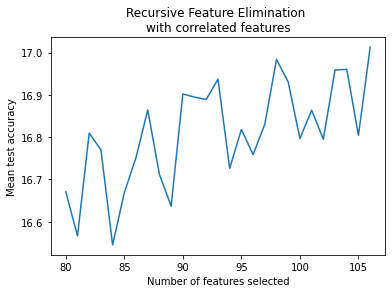

In [21]:
n_scores = len(selector_cb.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(80, n_scores + 80),
    np.abs(selector_cb.cv_results_["mean_test_score"]),
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

## Modelling

In [32]:
## ambil fitur yang sudah dipilih sebelumnya pada feature selection 

## stratified shuffle 
X = df_train_merge.drop(columns= cols_drop + list(["rain_sum"]))

y = df_train_merge.rain_sum

X_train, y_train = X[X.time < "2021-01-01"], y[X.time < "2021-01-01"]
X_test, y_test = X[X.time >= "2021-01-01"], y[X.time >= "2021-01-01"]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10960, 165), (2238, 165), (10960,), (2238,))

In [35]:
#Preprocessing
#COMMON
num_col_new = ['day',"week","dayofyear","minute_sunset","long_days"]

numerical_columns = X_train.select_dtypes("number").columns.tolist() + num_col_new 
categorical_columns = X_train.select_dtypes("object").columns.tolist() 

preprocessor = ColumnTransformer([
    ('numeric', num_pipe(transform = "yeo-johnson"), numerical_columns),
    ('categoric', cat_pipe(encoder='ordinal'),categorical_columns),
],remainder="drop")

pipeline = Pipeline([  
        ('custom', get_date()),
        ('prep', preprocessor), 
        ('model', None)
    ])

In [36]:
from sklearn.linear_model import LinearRegression, ElasticNet
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import KFold,RepeatedKFold 
from sklearn.ensemble import HistGradientBoostingRegressor
from copy import deepcopy

list_model = {
            "LGBM" : LGBMRegressor(random_state = 701,n_jobs = -1),
            "XGB" : XGBRegressor(random_state = 701,n_jobs = -1), 
            "CatBoost" : CatBoostRegressor(random_seed=701,silent = True)
}

metric = mean_squared_error
scorer = "neg_mean_squared_error"
num_cv = 5
cv = RepeatedKFold(n_splits = num_cv,n_repeats = 2,random_state = 701)

model_dict = train_model(list_model,X_train,y_train,X_test,y_test,metric,cv,scorer,pipeline)

model LGBM selesai di training
score test 14.040222738509376
score cv -18.126980521387573
score train 5.115534257264269
model XGB selesai di training
score test 15.864528318118952
score cv -20.524011012630005
score train 1.078537939894383
model CatBoost selesai di training
score test 12.692208405507973
score cv -16.509993348023027
score train 2.752711592094952


### Ensembling Model 

In [38]:
from sklearn.ensemble import VotingRegressor
import numpy as np

class CustomStacking(VotingRegressor):
    def predict(self, X):
        predictions = super().predict(X)
        #  make sure prediction is greater or equal to zero
        return np.maximum(predictions, 0)

In [40]:
estimators = [
        ("CatBoost1" , CatBoostRegressor(random_seed=44,silent = True)),
        ("CatBoost2" , CatBoostRegressor(random_seed=43,silent = True)),
        ("CatBoost3" , CatBoostRegressor(random_seed=42,silent = True))
]

list_model = {
    "average" : CustomStacking(estimators = estimators,weights = [1,1,1])
}

metric = mean_squared_error
scorer = "neg_mean_squared_error"
num_cv = 5
cv = RepeatedKFold(n_splits = num_cv,n_repeats = 2,random_state = 701)

model_dict_stc = train_model(list_model,X_train,y_train,X_test,y_test,metric,cv,scorer,pipeline)

model average selesai di training
score test 12.771930112798909
score cv -16.255003225655276
score train 2.5914436831467103


In [47]:
%%capture 
!pip install lazypredict

In [50]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(transform = "yeo-johnson"), numerical_columns),
    ('categoric', cat_pipe(encoder='ordinal'),categorical_columns),
],remainder="drop")

pipeline = Pipeline([  
        ('custom', get_date()),
        ('prep', preprocessor), 
    ])

In [51]:
X_train_trans = pd.DataFrame(pipeline.fit_transform(X_train),columns = numerical_columns + categorical_columns,index = X_train.index)
X_test_trans = pd.DataFrame(pipeline.fit_transform(X_test),columns = numerical_columns + categorical_columns,index = X_test.index)

## Submission

In [46]:
df_test["rain_sum (mm)"] = model_dict.model[0].predict(df_test_merge)
df_sub = df_test["rain_sum (mm)"]
df_sub.to_csv("submission_lgb.csv")

In [41]:
df_test["rain_sum (mm)"] = model_dict_stc.model[0].predict(df_test_merge)
df_sub = df_test["rain_sum (mm)"]
df_sub.to_csv("submission_cb.csv")

In [42]:
df_sub

id
0       0.039857
1       0.556252
2       0.000000
3       0.000000
4       0.000000
          ...   
4967    0.000000
4968    0.000000
4969    0.000000
4970    0.002102
4971    0.000000
Name: rain_sum (mm), Length: 4972, dtype: float64